# Pemodelan Klasifikasi Regresi Logistik Multinomial 

## Import library

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import joblib
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Load data

In [ ]:
data = pd.read_csv('/content/label_data_prabowo.csv')
data.dropna(subset=['cleaned'], inplace=True)
print(data.shape)
print(data.head())
print(data.duplicated().any()) 
print(data.isnull().any() )
print(data.shape)

(4040, 8)
         date                                                url  \
0  2022-11-30  https://twitter.com/Mewmewtho/status/159806777...   
1  2022-11-30  https://twitter.com/fadhlierlanda/status/15979...   
2  2022-11-30  https://twitter.com/ZimanPargaD/status/1597960...   
3  2022-11-30  https://twitter.com/chandrajuni82/status/15979...   
4  2022-11-30  https://twitter.com/Gardabangsaa/status/159792...   

        username                                            content  \
0      Mewmewtho  @azwarsiregar @solehuddin_plg @prabowo Kadrun ...   
1  fadhlierlanda  @PrayudhaRangga @azwarsiregar @prabowo Saya ma...   
2    ZimanPargaD  @Irwan2yah @DivHumas_Polri @Puspen_TNI @tni_ad...   
3  chandrajuni82  Survey pernah memenangkan @prabowo yang jadi p...   
4   Gardabangsaa  Lembaga survei Median merilis hasil simulasi h...   

                                             cleaned  \
0     kadrun sejati pilih ideologi kuat pikir sempat   
1  kampanye tunjuk kemampuanya komunikasi 

## Splitting data

In [ ]:
SEED = 2022
X = data
y = data['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

In [ ]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [ ]:
X_data = X_test
X_test = X_test['cleaned']
X_train = X_train['cleaned']

## Fitting model

In [ ]:
model = LogisticRegression(multi_class='multinomial', max_iter=1000)
vectorizer = TfidfVectorizer(lowercase=True)

In [ ]:
pipe= Pipeline([('vectorizer',vectorizer),('classifier',model)])

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
fold_num = 1
scores = []

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.loc[train_index], X_train.loc[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    pipe.fit(X_train_fold, y_train_fold)
    y_pred_fold = pipe.predict(X_test_fold)
    score = f1_score(y_test_fold, y_pred_fold, average='weighted')
    scores.append(score)
    print('Fold: %2d, F1-score: %.3f' % (fold_num, score*100))
    fold_num += 1

print('\n\nCross-Validation f1-score: %.3f +/- %.3f' %(np.mean(scores)*100, np.std(scores)))

Fold:  1, F1-score: 79.237
Fold:  2, F1-score: 80.198
Fold:  3, F1-score: 77.106
Fold:  4, F1-score: 81.112
Fold:  5, F1-score: 75.511
Fold:  6, F1-score: 80.255
Fold:  7, F1-score: 82.347
Fold:  8, F1-score: 78.904
Fold:  9, F1-score: 83.344
Fold: 10, F1-score: 77.887


Cross-Validation f1-score: 79.590 +/- 0.023


## Pendugaan parameter

In [ ]:
feature_names = pipe.named_steps['vectorizer'].get_feature_names()
pendugaan_parameter = pd.DataFrame(feature_names, columns=['features'])

pendugaan_parameter['g1'] = pipe.named_steps['classifier'].coef_[0]
pendugaan_parameter['g2'] = pipe.named_steps['classifier'].coef_[2]
pendugaan_parameter = pd.DataFrame([['Intersep', pipe.named_steps['classifier'].intercept_[0], pipe.named_steps['classifier'].intercept_[2]]], columns=pendugaan_parameter.columns).append(pendugaan_parameter)
pendugaan_parameter.to_csv('pendugaan_parameter_prabowo.csv', encoding='utf8', index=False)
pendugaan_parameter

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,features,g1,g2
0,Intersep,-0.779633,0.153493
0,abad,-0.104413,-0.233307
1,abadi,0.054352,-0.642401
2,abah,-0.034067,-0.085530
3,abal,-0.081886,0.229041
...,...,...,...
3233,zayed,-0.192744,0.288356
3234,zina,0.221358,-0.097554
3235,zon,0.141197,-0.075784
3236,zona,0.254336,-0.044215


## Prediksi data uji

In [ ]:
y_pred = pipe.predict(X_test)
final_score = f1_score(y_test, y_pred, average='weighted')*100
final_score.round(3)

80.049

## Confusion matrix

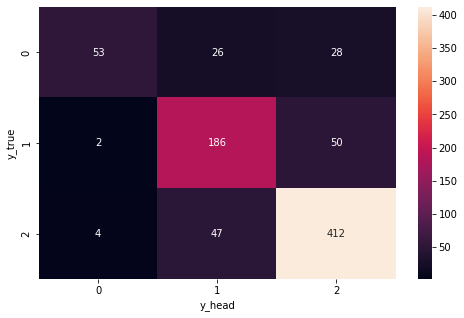

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_head")
plt.ylabel("y_true")
plt.show()

## Menyimpan file model

In [ ]:
# save the model
filename = 'prabowo_model.sav'
joblib.dump(pipe, filename)

['prabowo_model.sav']

# Prediksi data input

## Load library

In [ ]:
print("Detecting environment: ", end=' ')
try:
    import google.colab
    IN_COLAB = True
    print("Running the code in Google Colab. Installing and downloading dependencies.\nPlease wait...")
    import nltk
    !wget https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/lib/taudataNlpTm.py
    !mkdir data
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/slang.txt
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/stopwords_id.txt
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/stopwords_en.txt
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/corpus_sederhana.txt
    !pip install unidecode textblob sastrawi
    nltk.download('popular')
except:
    IN_COLAB = False
    print("Running the code locally.")

Detecting environment:  Running the code in Google Colab. Installing and downloading dependencies.
Please wait...
--2023-01-24 22:34:10--  https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/lib/taudataNlpTm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5686 (5.6K) [text/plain]
Saving to: ‘taudataNlpTm.py’

taudataNlpTm.py     100%[===================>]   5.55K  --.-KB/s    in 0s      

2023-01-24 22:34:10 (67.6 MB/s) - ‘taudataNlpTm.py’ saved [5686/5686]

--2023-01-24 22:34:11--  https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/slang.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuse

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import string
from unidecode import unidecode
from html import unescape
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.pipeline import Pipeline
import joblib
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

## Load stopwords

In [ ]:
# Loading Stopwords: Ada beberapa cara
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
factory = StopWordRemoverFactory()

NLTK_StopWords = stopwords.words('indonesian')
Sastrawi_StopWords_id = factory.get_stop_words()

df=open('data/stopwords_id.txt',"r",encoding="utf-8", errors='replace')
id_stop = df.readlines()
df.close()
id_stop = [t.strip().lower() for t in id_stop]

with open('more_stopwords.txt', 'r') as f:
    kamus = f.readline().split(',')
    more_stopwords = []
    for x in kamus:
        text = re.sub('[\s]+', '', x)
        more_stopwords.append(text)

with open('exclude_stopwords.txt', 'r') as f:
    kamus = f.readline().split(',')
    exclude_stopwords = []
    for x in kamus:
        text = re.sub('[\s]+', '', x)
        exclude_stopwords.append(text)

N = 10
print(NLTK_StopWords[:N])
print(Sastrawi_StopWords_id[:N])
print(id_stop[:N])
#print(more_stopwords[:N])
print(len(Sastrawi_StopWords_id), len(id_stop), len(NLTK_StopWords), len(more_stopwords))
print(type(Sastrawi_StopWords_id), type(id_stop), type(NLTK_StopWords), type(more_stopwords))

#Stopword
stops = set(Sastrawi_StopWords_id + id_stop + NLTK_StopWords + more_stopwords)
#exclude = ["tidak", 'benar', 'betul', 'baik', 'belum', 'boleh', 'dekat', 'guna', 'mampu', 'masalah', 'nggak', 'pasti', 'penting', 'percuma', 'rasa', 'satu', 'tegas', 'tunjuk', 'yakin', 'usah']
exclude = exclude_stopwords
for i in exclude:
  stops.discard(i)
print(len(stops))

['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir']
['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua']
['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir']
126 758 758 1353
<class 'list'> <class 'list'> <class 'list'> <class 'list'>
1659


## Load slang words

In [ ]:
# sumber github
indo_slang_words = pd.read_csv("https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv")
indo_slang_words = indo_slang_words.iloc[:,:2]
print('jumlah slang words: ', len(indo_slang_words))
# sumber tau data
df=open('data/slang.txt',"r",encoding="utf-8", errors='replace')
slangS = df.readlines(); df.close()
slangS = [t.strip('\n').strip() for t in slangS] # remove enter
slangS = [t.split(":") for t in slangS] # split based on ':'
slangS = [[k.strip(), v.strip()] for k,v in slangS] # remove white space
slangS = np.array(slangS) # convert to numpy
slang = slangS[:,0]
formal = slangS[:,1]
more_slang_words = pd.DataFrame(slangS[:,0], columns=['slang'])
more_slang_words['formal'] = formal
print('jumlah slang words: ', len(more_slang_words))
# combine slang words
all_slang_words = pd.concat([indo_slang_words, more_slang_words])
all_slang_words.drop_duplicates(subset='slang', keep='first', inplace=True)
print('jumlah slang words: ', len(all_slang_words))
slang_words = all_slang_words.set_index('slang').T.to_dict(orient='records')
dict_slang_words = slang_words[0]
print('kata normal dari kata 7an yaitu: ', dict_slang_words['7an'])

jumlah slang words:  15006
jumlah slang words:  1692
jumlah slang words:  5515
kata normal dari kata 7an yaitu:  tujuan


## Fungsi text preprocessing

In [ ]:
#Emoji
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

def hashtags(text):
  """Menyimpan hashtags"""
  getHashtags = re.compile(r"#(\w+)")
  pisahtags = re.compile(r'[\w][^A-Z]*')
  tagS = re.findall(getHashtags, text)
  for tag in tagS:
      proper_words = ' '.join(re.findall(pisahtags, tag))
      text = text.replace('#'+tag,proper_words)
  return text

def removeConsecutiveDuplicates(text):
    if len(text) < 2:
        return text
    if text[0] != text[1]:
        return text[0]+removeConsecutiveDuplicates(text[1:])
    return removeConsecutiveDuplicates(text[1:])

def normalization(text):
  T = TextBlob(text).words
  for i,t in enumerate(T):
      if t in dict_slang_words.keys():
          T[i] = dict_slang_words[t]
  return ' '.join(T)

def datePreproc(date):
    date = re.sub('(T[\w:+]*)', '', str(date))
    return date

urlPattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

def caseFolding(text):
    #Convert to lower case
    text = text.lower()
    return text

def cleansing1(text):
    #Get hashtags
    #text = hashtags(text)
    #Remove hashtags
    text = re.sub('#(\w+)', ' ', text)
    #Remove enter
    text = re.sub('(\n)', ' ', text)
    #Representasi ASCII terdekat
    text = unidecode(text)
    #Clean html entity
    text = unescape(text)
    #Remove emoji
    text = emoji_pattern.sub(r'', text)
    #Remove email
    text = re.sub('[\w._%+-]+@[\w\.-]+\.[a-zA-Z]{2,4}', ' ', text)
    #Remove @username
    text = re.sub('@[\w]*', ' ', text)
    #Remove Website URLS
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)
    #Remove additional white spaces
    text = re.sub('[\s]+', ' ', text)
    return text

def cleansing2(text):
    #Remove punctuation
    text = re.sub(r'[^\w\s]|_', ' ', text)
    #Remove number
    text = re.sub('[\d]+', ' ', text)
    #Remove double character
    text = removeConsecutiveDuplicates(text) #https://www.geeksforgeeks.org/remove-consecutive-duplicates-string/
    #Remove additional white spaces
    text = re.sub('[\s]+', ' ', text)
    return text

def stopwordRemover(word_tokens):
    '''input berupa kalimat yang sudah ditoken (from nltk.tokenize import word_tokenize)'''
    word_no_stopwords = [w for w in word_tokens if not w in stops]
    word_no_stopwords = " ".join(word_no_stopwords)
    return word_no_stopwords

def preprocess(text):
    stemmer = StemmerFactory().create_stemmer()
    text = str(text)
    text = cleansing1(text) 
    lower_text = caseFolding(text) 
    formal_text = normalization(lower_text) 
    clean_text = cleansing2(formal_text) 
    words = word_tokenize(clean_text) 
    text = stopwordRemover(words)
    text = stemmer.stem(text)
    return text

## Load model

In [ ]:
loaded_model = joblib.load('/content/prabowo_model.sav')
vectorizer = TfidfVectorizer(lowercase=True)
pipe= Pipeline([('vectorizer', vectorizer),
                ('classifier', loaded_model)])

## Melakukan prediksi

In [ ]:
print("Coba prediksi sentimen suatu kalimat.")
run = 'y'
while run == 'y':
    text = input("Masukkan kalimat yang akan dilakukan prediksi sentimen: ")
    text = preprocess(text)
    X_test = []
    X_test.append(text)
    preds = loaded_model.predict(X_test)
    print("Kalimat tersebut memiliki sentimen: {}".format(preds[0]))
    run = input("Apakah ingin mencoba kembali? (y/n): ")
print("Terima kasih dan sampai jumpa.")

Coba prediksi sentimen suatu kalimat.
Masukkan kalimat yang akan dilakukan prediksi sentimen: @prabowo keren sukses
Kalimat tersebut memiliki sentimen: Positif
Apakah ingin mencoba kembali? (y/n): y
Masukkan kalimat yang akan dilakukan prediksi sentimen: @prabowo calon abadi
Kalimat tersebut memiliki sentimen: Netral
Apakah ingin mencoba kembali? (y/n): y
Masukkan kalimat yang akan dilakukan prediksi sentimen: @prabowo biarin jadi calon abadi
Kalimat tersebut memiliki sentimen: Netral
Apakah ingin mencoba kembali? (y/n): y
Masukkan kalimat yang akan dilakukan prediksi sentimen: @prabowo bersinergi
Kalimat tersebut memiliki sentimen: Netral
Apakah ingin mencoba kembali? (y/n): n
Terima kasih dan sampai jumpa.
